# Introduction to PyMC

This notebook contains a very brief introduction to PyMC.
First, we import some dependencies.
PyMC is used to build probabilistic models and run inference.
Arviz can be used to visualize the results.
In addition, we will use numpy to work with arrays of data.

In [1]:
import pymc as pm
import arviz as az

import numpy as np

## Defining a model

When defining a model with PyMC, we need at least two elements:
- a `pm.Model` object to store the model
- a set of random variables in this model

We can create a model using `pm.Model()`.
This constructor function can take some optional arguments,
as we will see later.
The most convenient way to work with a model is to use a `with` block,
which will "enter" the model.
All the code in the `with` block will implicitly use this model.
If we give the model a name using `with pm.Model() as model_name:`,
we can enter it again at a later point using `with model_name`.

A model is written as if we would write a program that is supposed to generate the data,
i.e., the generative process.
Deterministic computations are described as regular code,
random decisions use *distributions*.
For example, a coin flip is implemented using `pm.Bernoulli()`.
Each distribution takes a name that identifies the random variables,
as well as the necessary parameters
(which could be fixed or themselves the results of random decisions).

Let's start by implementing a simple version of the regularity model:
- we set a fixed regularity $r$
- for each pattern $i$ (out of 10):
  - for each beat $b$ (out of 2, 3, 4):
    - flip a coin($r$) to determine if the previous beat is repeated or not.

We can use ordinary `for` loops to implement the loops in this model,
but we have to give every variable inside the loops a different name,
so we will use the loop index to name the variables.
We will see a better way to implement this later.

In [2]:
with pm.Model() as regularity_model_gen:
    # set the regularity
    regularity = 0.1
    for i in range(10): # generate 10 patterns
        for beat in range(1,4): # beats 2-4
            # sample each beat in each pattern
            pm.Bernoulli(f"pattern{i}_b{beat}", # name of the variable
                         regularity, # parameter of the distribution
                        )

Let's look at the architecture of this model:

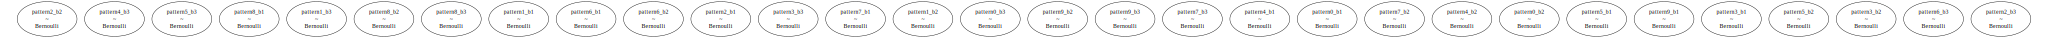

In [3]:
pm.model_to_graphviz(regularity_model_gen)

As you can see, the model consists of a series of independent variables,
one for each beat in each pattern.

We can run this model as it is using the function `pm.sample_prior_predictive(n)`,
where `n` determines the numbers of draws.
To draw from the model once, we first enter the model again (using `with`)
and then call the function with `n=1`:

In [4]:
with regularity_model_gen:
    output1 = pm.sample_prior_predictive(1)

Sampling: [pattern0_b1, pattern0_b2, pattern0_b3, pattern1_b1, pattern1_b2, pattern1_b3, pattern2_b1, pattern2_b2, pattern2_b3, pattern3_b1, pattern3_b2, pattern3_b3, pattern4_b1, pattern4_b2, pattern4_b3, pattern5_b1, pattern5_b2, pattern5_b3, pattern6_b1, pattern6_b2, pattern6_b3, pattern7_b1, pattern7_b2, pattern7_b3, pattern8_b1, pattern8_b2, pattern8_b3, pattern9_b1, pattern9_b2, pattern9_b3]


Let's look at the output. we get an object of type `InferenceData`
which can hold the outputs for several kinds of inferences at the same time.
(Sampling from the distribution is one kind of output).

If you run this code in a notebook, you can see a nice interactive version of the data,
where you can look inside the "prior" set.
It will contain some metadata (such as dimensions),
but most importantly a set of "data variables",
which are the actual output.
You can see one row for each variable of the model,
and since we only drew 1 sample from the model,
each of them has a single random value.

In [5]:
output1

Inference data with groups:
	> prior

## Running inference

If we want to run an inference (i.e., obtaining the posterior distribution of the regularity),
we need to change the above model a little bit.

First of all, we need some data:

In [6]:
data_group1 = np.array([
    [1, 1, 1], # pattern 1: *rrr
    [0, 0, 0], # pattern 2: *nnn
    [1, 0, 1], # pattern 3: *rnr
])
data_group1

array([[1, 1, 1],
       [0, 0, 0],
       [1, 0, 1]])

Then we need to change two things in the model.
1. The regularity itself needs to be a random variable that is drawn from its prior distribution.
2. The model needs to know that we have observations for the data variables.
   We can do that by adding the `observed` keyword to the `Bernoulli` distribution
   and providing the right value.

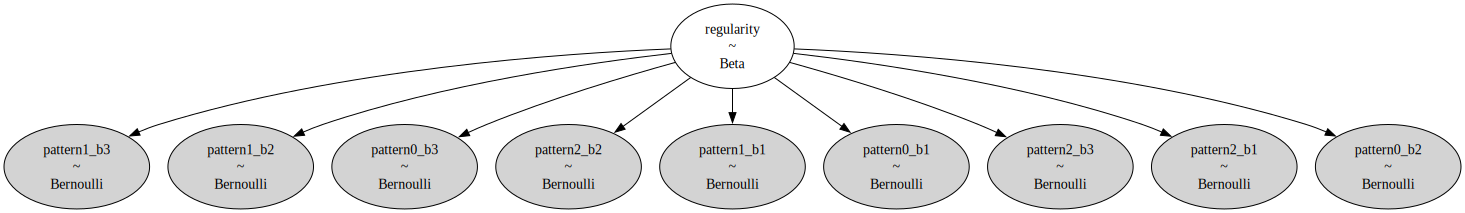

In [7]:
with pm.Model() as regularity_model_inf:
    # sample the regularity from its prior.
    # We could also use Beta(1,1), which is a uniform distribution between 0 and 1.
    regularity = pm.Beta("regularity", # name of the variable
                         0.5, # parameter alpha
                         0.5 # parameter beta
                        )
    for i in range(3): # the data have only 3 patterns
        for beat in range(1,4): # beats 2-4
            # sample each beat in each pattern
            pm.Bernoulli(f"pattern{i}_b{beat}", # name of the variable
                         regularity, # parameter of the distribution
                         observed=data_group1[i, beat-1] # observed value
                        )

pm.model_to_graphviz(regularity_model_inf)

If we plot the model structure,
we still see a bunch of separate varibles for the beats,
but all of them are
- grey because they are observed now
- connected to the regularity variable, because the regularity influences their outcomes.

Now we can estimate the posterior distribution by drawing a sample from it with a certain number of draws.
The larger the sample size, the more accurate the estimate.
This is done using the function `pm.sample()`:

In [8]:
with regularity_model_inf:
    idata2 = pm.sample(5000) # draw a sample of size 5000 from the posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


We can look at the inference data just like before.
This time, it will contain a `posterior` set,
which in turn contains a sample of the latent variable `regularity`.

In [9]:
idata2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

One thing to notice is that the infernce data contains not just 5,000 draws but in fact 20,000.
That is because the simluation used to obtain the draws is run several times, in 4 "chains" in this case.
This makes the results more reliable than running a single long simulation,
and the number of chains can be controlled in the `pm.sample()` function.

Let's look at the distribution of the sample.
We can easily do that using the arviz package,
with `az.plot_posterior()`:

<Axes: title={'center': 'regularity'}>

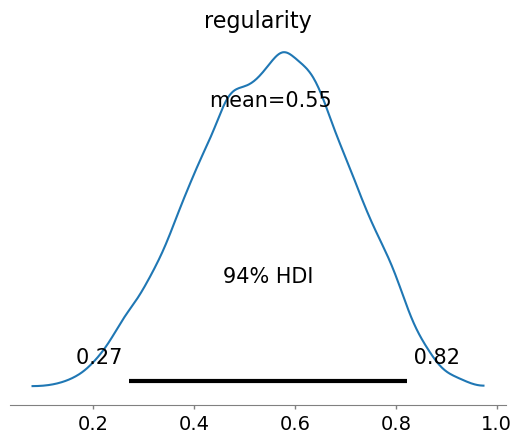

In [10]:
az.plot_posterior(idata2)

As you can see, the true regularity underlying the data is probably somewhere around 0.55,
but there is a lot of uncertainty because the dataset is so small that a reliable estimate is impossible.

## Vectorization

If you have worked with python before,
you have probably heard that for-loops are slow.
When working with larger amounts of data,
it is usually a better idea to *vectorize* your code,
i.e. to work with arrays of data instead of individual values that you have to iterate over.

We can easily do that with our model:
All the coin flips work exactly the same,
they have the same distribution and only differ in their "position"
(pattern and beat).
With PyMC, we can turn your set of Bernoulli variables into one multi-dimensional
(or *multivariate*) variable using the `shape` keyword parameter.
In our case, the shape consists of the number of patterns times the number of beats per pattern.

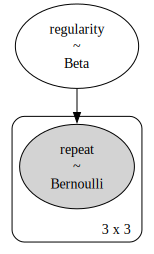

In [11]:
with pm.Model() as regularity_model_vec:
    # sample the regularity from its prior.
    regularity = pm.Beta("regularity", 0.5, 0.5)
    # sample each beat in each pattern
    pm.Bernoulli("repeat", # name of the variable
                 regularity, # parameter of the distribution
                 shape=(3,3), # shape of the variable (patters x beats)
                 observed=data_group1 # observed data
                )

pm.model_to_graphviz(regularity_model_vec)

This already makes for a much cleaner model (only two variables, one of which is multivariate),
and it should also lead to faster performance (at least if the dataset was much larger).

But it can be a bit complicated to work with these multi-dimensional variables.
For example, which dimension corresponds to the patterns and which to the beats?
Both of them have size 3.

To make this a bit more explicit, PyMC supports *named dimensions*.
Instead of giving the shape of the Bernoulli variable as bare numbers,
we can define a set of "coordinates" for the pattern and the beat dimension,
i.e. lists of possible values that they can take.
This is particularly convenient since we not only get a name for each dimension,
we can also use other indices than numbers!
For example, we care about a repetition for beats 2 - 4,
so instead of using the indices 0, 1, and 2, we could use the strings
`beat2`, `beat3`, and `beat4`, which is much more semantic.

To integrate named dimensions in our model,
let's first define the coordinates in a dictionary,
mapping a dimension name to the list of values:

In [12]:
coords = {
    "pattern": range(3),
    "beat": ["beat2", "beat3", "beat4"]
}

If we pass these coordinates to the model,
we can use the dimension names to specify the shape of the variables in the model,
using the keyword `dims=` instead of `shape=`.
We can even see the dimension names in the model plot.

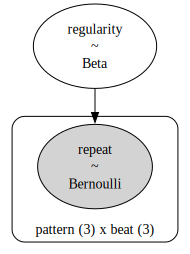

In [13]:
with pm.Model(coords=coords) as regularity_model_coords:
    # sample the regularity from its prior.
    regularity = pm.Beta("regularity", 0.5, 0.5)
    # sample each beat in each pattern
    pm.Bernoulli("repeat", # name of the variable
                 regularity, #parameter of the distribution,
                 dims=("pattern", "beat"), # names of the dimensions (with known coordinates)
                 observed=data_group1 # observed data
                )

pm.model_to_graphviz(regularity_model_coords)

Let's now sample from this model's posterior:

In [14]:
with regularity_model_coords:
    idata_coords = pm.sample(5000)

idata_coords

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

You might have guessed that the "dimensions" `chain` and `draw` are the same kind of dimensions
as the dimensions that we defined ourselves.
They also both have a set of possible values (coordinates),
and we can use them to select draws from the postior sample.
The most convenient way to do that is to use the method `.sel()`,
with the dimensions as keyword arguments:

In [15]:
idata_coords.posterior.sel(chain=2, draw=238)

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    chain       int64 2
    draw        int64 238
Data variables:
    regularity  float64 0.5308
Attributes:
    created_at:                 2024-01-17T16:51:42.106286
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              2.3945348262786865
    tuning_steps:               1000

This gives you an excerpt (slice) of the entire posterior.
You can also zoom in on a single variable using `.data_vars["variable"]`:

In [16]:
idata_coords.posterior.data_vars["regularity"].sel(chain=2, draw=238)

<xarray.DataArray 'regularity' ()>
array(0.53083277)
Coordinates:
    chain    int64 2
    draw     int64 238

If you want to get the value as it is instead of another `DataArray` object, use `.item()`:

In [17]:
idata_coords.posterior.data_vars["regularity"].sel(chain=2, draw=238).item()

0.5308327706550671

Here is another little example where we sample new data from the model's prior.
Note that the sample values are distributed across two different sets in the inference data:
- `prior` for latent variables
- `prior_predictive` for variables that would normally be observed

In [18]:
with regularity_model_coords:
    # sample 4 new "datasets"
    idata_coords_prior = pm.sample_prior_predictive(4)

idata_coords_prior
    
for draw in idata_coords_prior.prior.coords["draw"]: # use .coords to iterate over all possible values for "draw"
    print(f"draw {draw.item()}:")
    # select the data in the current draw:
    patterns = idata_coords_prior.prior_predictive.data_vars["repeat"].sel(chain=0, draw=draw)
    for pattern in patterns:
        # convert the pattern to a string notation
        pstr = "".join(np.array(["n", "r"])[pattern.to_numpy()])
        print(f"  *{pstr}")

Sampling: [regularity, repeat]


draw 0:
  *rrr
  *rrr
  *rrr
draw 1:
  *nnn
  *nnn
  *nnn
draw 2:
  *nnn
  *nrn
  *nnn
draw 3:
  *nnn
  *nnn
  *rnn


## Make the model more flexible

Another drawback of the above model is that the data are hardcoded.
What if we want to run the analysis for a second group of patterns?

In [19]:
data_group2 = np.array([
    [0, 0, 0], # pattern 1: *nnn
    [0, 0, 0], # pattern 2: *nnn
    [0, 1, 0], # pattern 3: *nrn
    [1, 1, 0], # pattern 4: *rrn
])
data_group2

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 1, 0]])

We could of course define the model again.
Or we could write a function that makes a model given some dataset.
However, PyMC also supports exchanging the data of a model,
but to do that, it needs to be wrapped in a `pm.MutableData` container:
1. Create a `MutableData` container with a name and an intial value (e.g. `data_group1`).
2. Instead of the data, use the container for the `observed=` keyword in observed variables.
3. Since the size of the data could change (e.g. 3 vs 4 patterns in groups 1 and 2, respectively),
   we can't use fixed coordinates for the `"pattern"` dimension.
   We can still use coordinates for the `"beat"` dimension and even an explicitly named `"pattern"` dimension in the
   `"repeat"` variable, but since the size of the `"pattern"` dimension changes,
   we have to pass an explicit `shape=` keyword to `pm.Bernoulli()`.
   The shape is normally a tuple of sizes (e.g. `(4,3)` for the data in group 2),
   but since the shape of the variable is the same as the shape of the data,
   we can just use the `.shape` attribute of the data container.

In [20]:
with pm.Model(coords={"beat": ["beat2", "beat3", "beat4"]}) as regularity_model_mut:
    # create a container for the data
    obs_ = pm.MutableData("data", data_group1) # needs an initial value
    # sample the regularity from its prior.
    regularity = pm.Beta("regularity", 0.5, 0.5)
    # sample each beat in each pattern
    pm.Bernoulli("repeat", # name of the variable
                 regularity, # parameter of the distribution
                 dims=("pattern", "beat"), # dimension names
                 shape=obs_.shape, # dimension sizes
                 observed=obs_ # observed data
                )

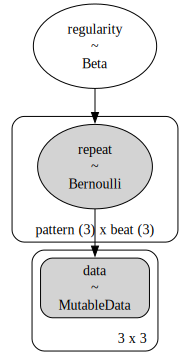

In [21]:
pm.model_to_graphviz(regularity_model_mut)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


<Axes: title={'center': 'regularity'}>

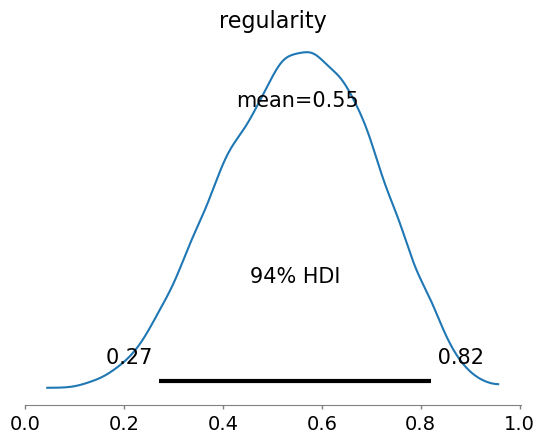

In [22]:
# observe group 1:
with regularity_model_mut:
    idata_g1 = pm.sample(5000)

az.plot_posterior(idata_g1)

In order to run the model with the data of group 2,
we replace the data in the `MutableData` container using `model.set_data()`.
We use the name of the container to determine, which data to replace
(there can be more than one data container per model).
You can see, that the dimensions of the data and the model change
since the second group contains more patterns!

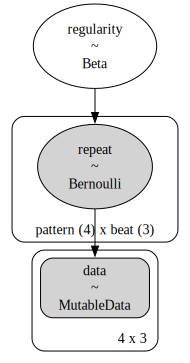

In [23]:
regularity_model_mut.set_data("data", data_group2)

pm.model_to_graphviz(regularity_model_mut)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


<Axes: title={'center': 'regularity'}>

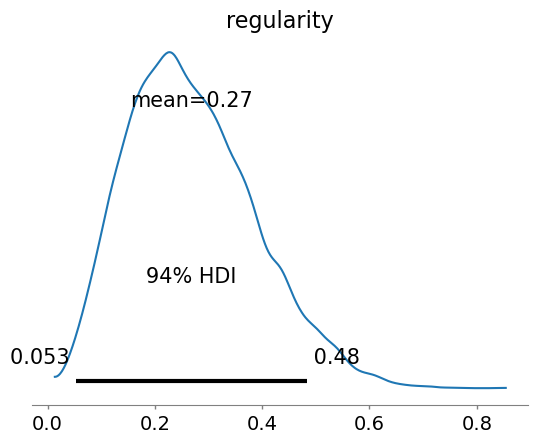

In [24]:
# observe group 2:
with regularity_model_mut:
    idata_g2 = pm.sample(5000)

az.plot_posterior(idata_g2)

## Bonus: Looking inside the Chains

The sampling is based on MCMC, so samples are drawn from one or several markov chains.
We can look at these chains in several ways.
The easiest one is to use `az.plot_trace()` instead of `az.plot_posterior()`.

By default. `pm.sample()` uses a "tuning" phase:
The first 1000 draws from the chain are discarded
because they don't reflect the stationary distribution of the chain yet.
We can set `tune=0` to see all the samples drawn from the chain.

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [regularity]


Sampling 3 chains for 0 tune and 200 draw iterations (0 + 600 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


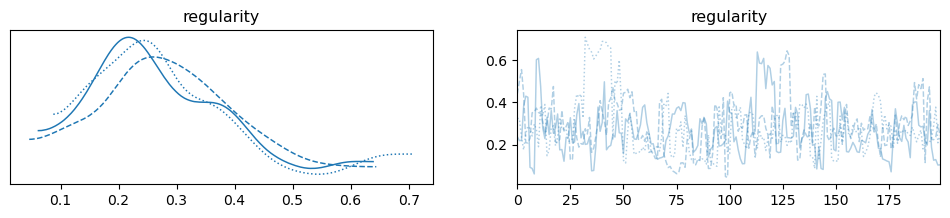

In [25]:
with regularity_model_mut:
    idata_notune = pm.sample(tune=0, draws=200, chains=3)

az.plot_trace(idata_notune);

In theory, we should run a (sufficiently long) chain for every draw,
taking only it's last state:

In [26]:
import seaborn as sns
sns.set_theme()

/home/chfin/miniforge3/envs/gmth-bayes-tutorial/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


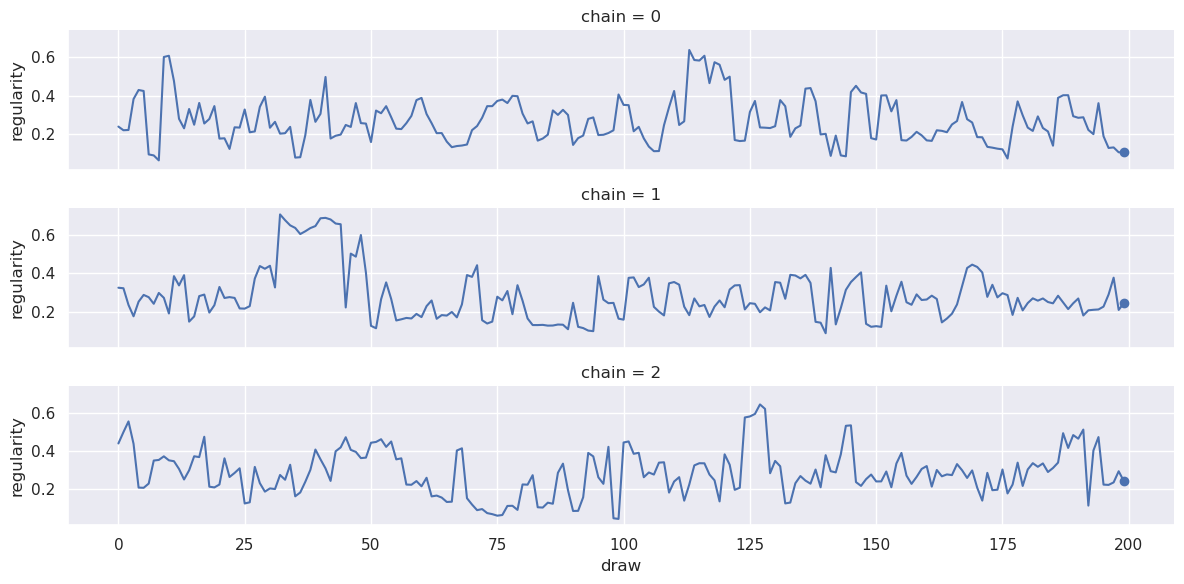

In [27]:
fig = sns.relplot(data=idata_notune.posterior.data_vars['regularity'].to_dataframe(),
                 x="draw", y="regularity", row="chain",
                 kind="line", aspect=6, height=2)
for i, axrow in enumerate(fig.axes):
    ax = axrow[0]
    ax.plot(199, idata_notune.posterior.regularity.sel(chain=i, draw=199).item(), 'o')
fig.savefig("img/mcmc.svg")

In practice, however,
we take all states of the chain except the first few (from the "tune" or "burn-in" phase):

/home/chfin/miniforge3/envs/gmth-bayes-tutorial/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


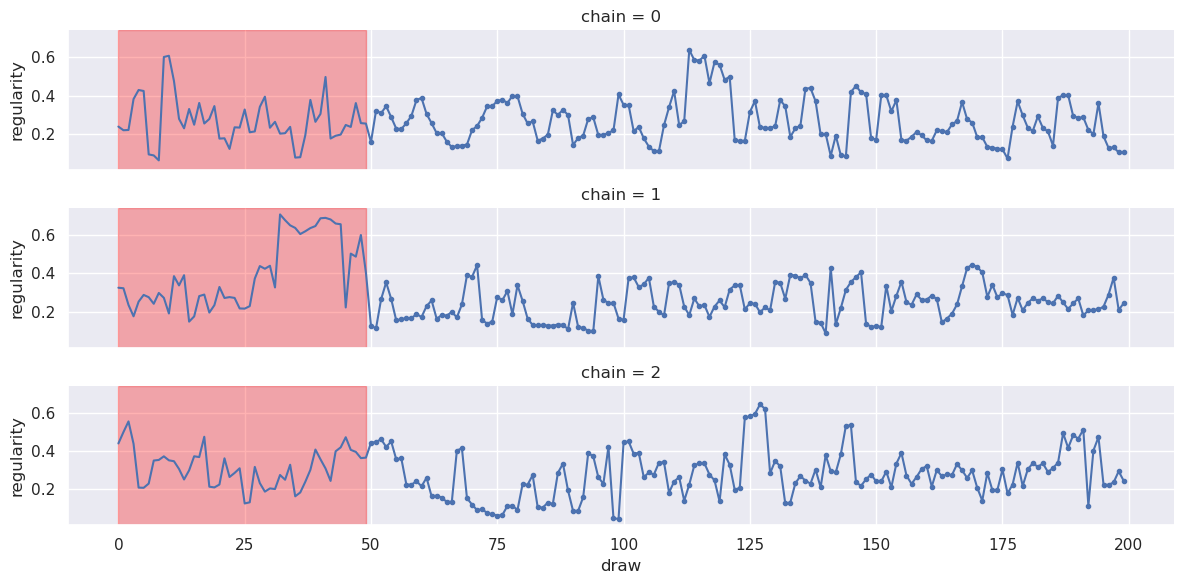

In [28]:
fig = sns.relplot(data=idata_notune.posterior.data_vars['regularity'].to_dataframe(),
                 x="draw", y="regularity", row="chain",
                 kind="line", aspect=6, height=2)
for i, axrow in enumerate(fig.axes):
    ax = axrow[0]
    ax.plot(np.arange(50,200), idata_notune.posterior.regularity.sel(chain=i).to_numpy()[range(50,200)], '.')
    ax.axvspan(0, 49, color='red', alpha=0.3)
fig.savefig("img/mcmc_full.svg")